In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from LB_D2Q9 import pipe_opencl as lb

We now want to visualize the evolution of the flow...let's see how it goes...

In [6]:
from IPython import display

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [7]:
#### Input to the simulation in SI. ######
diameter = 4. # meters
length = 10. # meters

deltaP = -0.2

dr = 0.02
dt = 4.

viscosity = 10.**-6. # More viscous = easier to simulate!

##### Derived parameters ######
print 'Desired viscosity:' , viscosity
#Re = (input_velocity * diameter)/viscosity
#print 'Desired Re', Re

# Re is set by diameter, input_velocity, and viscosity
# Adjust dr so that mach number doers not explode!
print
print '###### Simulation Parameters #########'
print

# Solve for the desired omega...make sure it's in the correct range.


ly = int(np.ceil(diameter/dr))
lx = int(np.ceil(length/dr))
print 'ly', ly
print 'lx', lx

nx = lx + 1
ny = ly + 1

omega = .5 + (3*dt*viscosity)/(dr**2)

print 'omega:' , omega

assert (omega > 0.5) and (omega < 1)

obstacle_size=.25 # meters

Desired viscosity: 1e-06

###### Simulation Parameters #########

ly 200
lx 500
omega: 0.53


In [8]:
nx*ny*9

906309

In [9]:
import skimage as ski
import skimage.draw

In [10]:
import sys

In [11]:
sim = lb.Pipe_Flow(lx=lx, ly=ly, dr=dr, dt=dt, omega=omega,
                  deltaP = deltaP)

# U should be on the order of 0.1, 0.2 in the simulation!
#print 'u_max in simulation:' , np.max(sim.u)

The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192, 8192, 8192]
---------------------------
This context is associated with  1 devices
Starting kernel...
Done!


/home/bryan/anaconda/lib/python2.7/site-packages/pyopencl/__init__.py:59: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz' on 'Intel(R) OpenCL' at 0x3450538> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <update_feq> was successfully vectorized (8)
Kernel <update_hydro> was successfully vectorized (8)
Kernel <collide_particles> was successfully vectorized (4)
Kernel <move> was successfully vectorized (4)
Kernel <move_bcs> was successfully vectorized (4)
Done.
  warn(text, CompilerWarning)
/home/bryan/anaconda/lib/python2.7/site-packages/pyopencl/__init__.py:59: CompilerWarning: From-binary build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz' on 'Intel(R) OpenCL' at 0x3450538> succeeded, but said:

Device build started
Device

In [12]:
print np.min(sim.get_fields_on_cpu()['f'][:, :, 3])
print np.min(sim.get_fields_on_cpu()['feq'][:, :, 3])

0.0107802
0.0111339


In [13]:
sim.move_bcs()

In [14]:
print np.min(sim.get_fields_on_cpu()['f'][:, :, 3])
print np.min(sim.get_fields_on_cpu()['feq'][:, :, 3])

0.0107802
0.0111339


In [15]:
sim.move()

In [16]:
print np.min(sim.get_fields_on_cpu()['f'][:, :, 3])
print np.min(sim.get_fields_on_cpu()['feq'][:, :, 3])

0.0107802
0.0111339


In [17]:
f3 = sim.get_fields_on_cpu()['f'][:, :, 8]

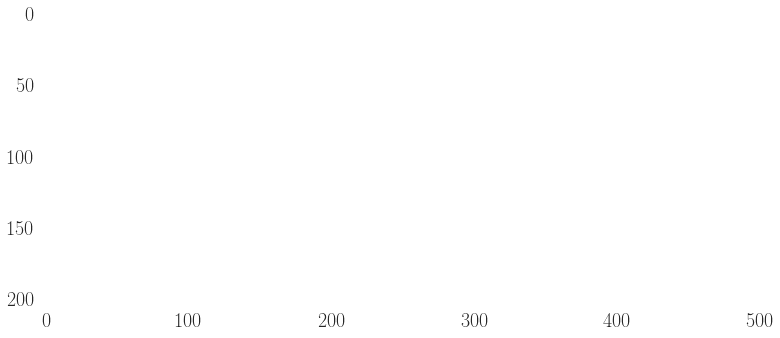

In [19]:
plt.imshow((f3==0).T)
plt.grid(False)

WTF lol this makes *zero* sense. The move function is messed up...this must be where the psychotic problems are coming from...

In [20]:
sim.update_hydro()

In [21]:
np.min(sim.get_fields_on_cpu()['f'][:, :, 3])

0.010837357

In [22]:
sim.update_feq()

In [23]:
np.min(sim.get_fields_on_cpu()['f'][:, :, 3])

0.010837357

In [24]:
sim.collide_particles()

In [25]:
np.min(sim.get_fields_on_cpu()['f'][:, :, 3])

0.0093370322

Oh interesting...maybe the collision is messed up.

In [27]:
sim.run(1)

<matplotlib.colorbar.Colorbar instance at 0x7fdd71479830>

/home/bryan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


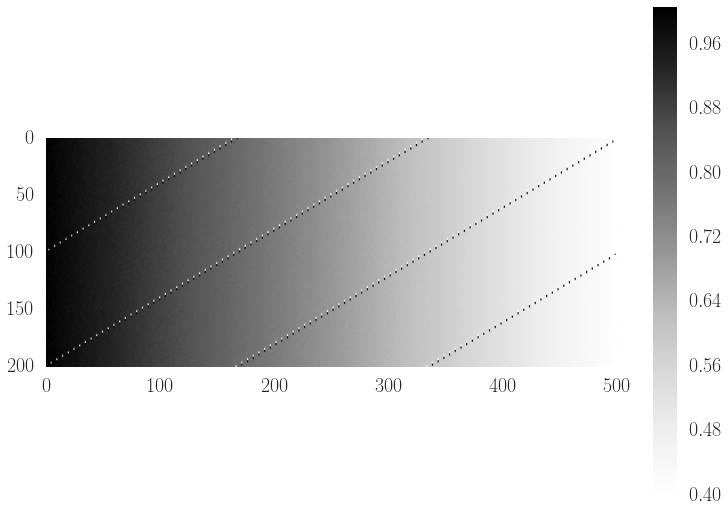

In [28]:
ruhroh = sim.get_fields_on_cpu()
plt.imshow(ruhroh['rho'].T)
plt.grid(False)
plt.colorbar()

Interesting...weird streaks are forming! Disaster...lol.

In [12]:
sim.run(100)

In [ ]:
total_num_steps = 5000
steps_per_image= 25

num_to_record = int(np.ceil(float(total_num_steps)/steps_per_image))

Re_list = []
Ma_list = []

plt.figure()
for i in range(num_to_record):
    sim.update_dimensionless_nums()
    Re_list.append(sim.Re)
    Ma_list.append(sim.Ma)
    print 'max non_dim u:', np.max(sim.u)
    print 'sum of mass' , np.sum(sim.rho)/(sim.nx*sim.ny)
    mag = np.sqrt(sim.u**2 + sim.v**2)
    plt.imshow(mag.T, cmap = cm.coolwarm)
    plt.grid(False)
    #plt.clim(vmin=0, vmax=1.)
    #if i == 0:
    #    plt.colorbar()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    sim.run(steps_per_image)
plt.clf() # This way a second figure does not appear at the end...

IDK how to convert...but let's just fit.

In [ ]:
plt.semilogy(Ma_list, ls='-', marker='.')

Nope, it's fucked! lol.

In [ ]:
plt.semilogy(Re_list, ls='-', marker='.')

Looks like it still hasn't converged. But, as expected, larger pressure differences leads to larger reynolds numbers!